# Invert models using GA

Let's see if GA can work better with the ints and constraints than the PSO

In [1]:
import numpy as np 
from geneticalgorithm import geneticalgorithm as ga
import pandas as pd
import os 
from lightgbm import LGBMRegressor
from sklearn.model_selection import train_test_split
DATADIR = '../data'
import sys 
sys.path.append('../')

from dispersant_screener.utils import plot_parity
from dispersant_screener.smiles2feat import get_smiles
# Some more magic so that the notebook will reload external python modules;
# see http://stackoverflow.com/questions/1907993/autoreload-of-modules-in-ipython
%load_ext autoreload
%autoreload 2

In [2]:
FEATURES = [
     'max_[Ta]',  'max_[W]', 'max_[R]', 'max_[Tr]', '[W]', '[Tr]', '[Ta]', '[R]',  'length'
]

In [3]:
FEAT_DICT = dict(zip(FEATURES, range(len(FEATURES))))

In [4]:
BEAD_INDICES = [
    FEAT_DICT['[W]'], FEAT_DICT['[Ta]'], FEAT_DICT['[Tr]'], FEAT_DICT['[R]'], FEAT_DICT['length']
]

In [5]:
df_full_factorial_feat = pd.read_csv(os.path.join(DATADIR, 'new_features_full_random.csv'))[FEATURES].values
a2 = pd.read_csv(os.path.join(DATADIR, 'b1-b21_random_virial_large_new.csv'))['A2_normalized'].values
deltaGMax = pd.read_csv(os.path.join(DATADIR, 'b1-b21_random_virial_large_new.csv'))['A2_normalized'].values
gibbs = pd.read_csv(os.path.join(DATADIR, 'b1-b21_random_deltaG.csv'))['deltaGmin'].values
gibbs_max = pd.read_csv(os.path.join(DATADIR, 'b1-b21_random_virial_large_new.csv'))['deltaGmax'].values
force_max = pd.read_csv(os.path.join(DATADIR, 'b1-b21_random_virial_large_fit2.csv'))['F_repel_max'].values
rg = pd.read_csv(os.path.join(DATADIR, 'rg_results.csv'))['Rg'].values
y = np.hstack([
    rg.reshape(-1, 1),
    gibbs.reshape(-1, 1),
    gibbs_max.reshape(-1, 1),
    force_max.reshape(-1, 1),
    deltaGMax.reshape(-1, 1),
    a2.reshape(-1, 1)
])
assert len(df_full_factorial_feat) == len(a2) == len(gibbs) == len(y)

In [6]:
lb = []
ub = []
vartype = []

for feat in FEATURES: 
    print(feat)
    if 'head' in feat:
        lb.append(0)
        ub.append(2)
        vartype.append(['int'])
    elif feat == 'length': 
        lb.append(16)
        ub.append(48)
        vartype.append(['int'])
    elif 'max' in feat: 
        lb.append(0)
        ub.append(32)
        vartype.append(['int'])
    else: 
        lb.append(0)
        ub.append(1)
        vartype.append(['real'])

max_[Ta]
max_[W]
max_[R]
max_[Tr]
[W]
[Tr]
[Ta]
[R]
length


In [7]:
target = y[:,1] * -1

In [8]:
vartype

[['int'],
 ['int'],
 ['int'],
 ['int'],
 ['real'],
 ['real'],
 ['real'],
 ['real'],
 ['int']]

In [9]:
bounds = list(zip(lb, ub))

In [10]:
def constrain_cluster(x): 
    pentalty = 0
    if x[FEAT_DICT['max_[W]']] > x[FEAT_DICT['[W]']] * x[FEAT_DICT['length']]: 
        pentalty += 30
    if x[FEAT_DICT['max_[Ta]']] > x[FEAT_DICT['[Ta]']] * x[FEAT_DICT['length']]: 
        pentalty += 30
    if x[FEAT_DICT['max_[Tr]']] > x[FEAT_DICT['[Tr]']] * x[FEAT_DICT['length']]: 
        pentalty += 30
    if x[FEAT_DICT['max_[R]']] > x[FEAT_DICT['[R]']] * x[FEAT_DICT['length']]: 
        pentalty += 30
    
    return pentalty

In [11]:
def constrain_validity(x): 
    smiles = get_smiles(dict(zip(FEATURES, x)), 1, 10)
    if smiles: 
        return -5
    else: 
        return 50

In [12]:
def constrain_length(x): 
    w = x[FEAT_DICT['[W]']]
    tr =x[FEAT_DICT['[Tr]']] 
    ta = x[FEAT_DICT['[Ta]']]
    r = x[FEAT_DICT['[R]']] 

    feat_length = x[FEAT_DICT['length']]
    length = round(w*feat_length) + round(tr*feat_length) + round(ta*feat_length) + round(r*feat_length)
    if length != feat_length:
        return 100

    return 0

In [13]:
def objective(x):
    y = MODEL.predict(x.reshape(1,-1))
    
    regularize_cluster = constrain_cluster(x)
#     regularize_length = constrain_length(x)
    regularize_validity = constrain_validity(x)
    regularizer_noverly = 1/ (np.min(np.linalg.norm(x - X_train, axis=1)))**2
    
    return - y +  regularizer_noverly + regularize_validity + regularize_cluster

In [14]:
# https://app.wandb.ai/kjappelbaum/dispersant_screener/runs/wog4qfb2/overview?workspace=user-kjappelbaum
config_1 ={
    "max_depth":  73,
    "reg_alpha": 1.392732983015451,
    "subsample":  0.5009306968568509,
    "num_leaves":  6,
    "reg_lambda": 1.0595847294980203,
    "n_estimators":  461,
    "colsample_bytree": 0.966043658485258,
    "min_child_weight": 0.0039362945584385705
}

In [15]:
X_train, X_test, y_train, y_test = train_test_split(df_full_factorial_feat, target, train_size=0.8)


In [16]:
lgbm_1 = LGBMRegressor(**config_1)

In [17]:
lgbm_1.fit(X_train, y_train)

LGBMRegressor(boosting_type='gbdt', class_weight=None,
              colsample_bytree=0.966043658485258, importance_type='split',
              learning_rate=0.1, max_depth=73, min_child_samples=20,
              min_child_weight=0.0039362945584385705, min_split_gain=0.0,
              n_estimators=461, n_jobs=-1, num_leaves=6, objective=None,
              random_state=None, reg_alpha=1.392732983015451,
              reg_lambda=1.0595847294980203, silent=True,
              subsample=0.5009306968568509, subsample_for_bin=200000,
              subsample_freq=0)

In [18]:
MODEL = lgbm_1 

 The best solution found:                                                                           
 [1.70000000e+01 1.70000000e+01 2.00000000e+00 0.00000000e+00
 3.55031646e-01 1.04375125e-02 4.26872775e-01 2.12398823e-01
 4.80000000e+01]

 Objective function:
 -19.57645441118771


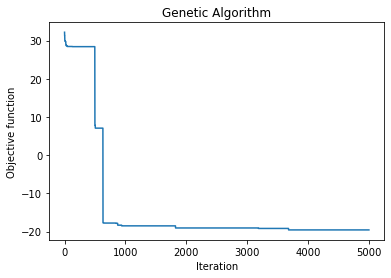

 The best solution found:                                                                           
 [5.00000000e+00 5.00000000e+00 2.30000000e+01 0.00000000e+00
 1.04315643e-01 2.81851565e-04 3.43740595e-01 5.72171782e-01
 4.80000000e+01]

 Objective function:
 -26.429673719338705


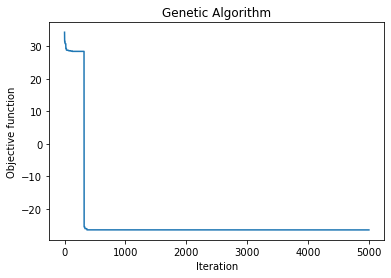

 The best solution found:                                                                           
 [4.00000000e+00 4.00000000e+00 2.00000000e+01 2.00000000e+00
 8.33942922e-02 4.20007653e-02 3.43536588e-01 5.51830713e-01
 4.80000000e+01]

 Objective function:
 -26.197577663909282


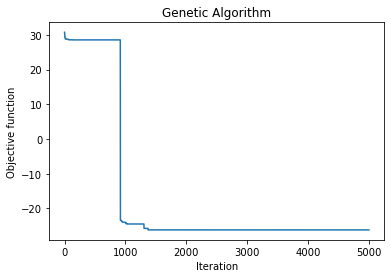

 The best solution found:                                                                           
 [5.00000000e+00 5.00000000e+00 2.10000000e+01 0.00000000e+00
 1.04221955e-01 1.06913623e-02 3.85379688e-01 5.10413731e-01
 4.80000000e+01]

 Objective function:
 -26.488788756688308


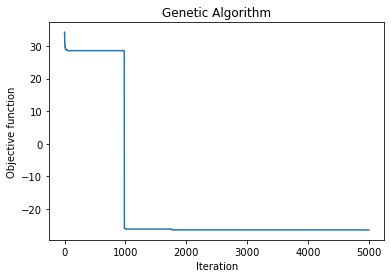

 The best solution found:                                                                           
 [5.00000000e+00 5.00000000e+00 1.80000000e+01 0.00000000e+00
 1.04284039e-01 1.04281144e-02 4.47784365e-01 4.47878825e-01
 4.80000000e+01]

 Objective function:
 -26.559841822508567


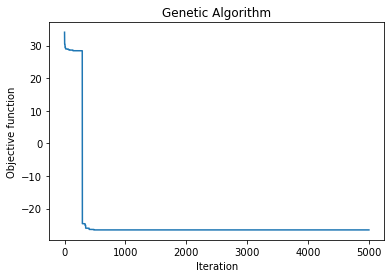

In [23]:
ga_models = []

for i in range(5):

    model=ga(function=objective,dimension=len(FEATURES),
             variable_type_mixed=np.array(vartype),
             variable_boundaries=np.array(bounds), algorithm_parameters={'max_num_iteration': 5000, 
                                                                         'elit_ratio': 0.02,
                                                                        'population_size':100,
                                                                       'mutation_probability':0.1,
                                                                       'crossover_probability': 0.5,
                                                                       'parents_portion': 0.3,
                                                                       'crossover_type':'uniform',
                                                                       'max_iteration_without_improv':None
                                                                        })
    model.run()
    ga_models.append(model)

 The best solution found:                                                                           
 [7.00000000e+00 7.00000000e+00 3.00000000e+00 0.00000000e+00
 1.45871058e-01 5.84188600e-05 4.68162567e-01 4.05339592e-01
 4.80000000e+01]

 Objective function:
 -26.16851874961442


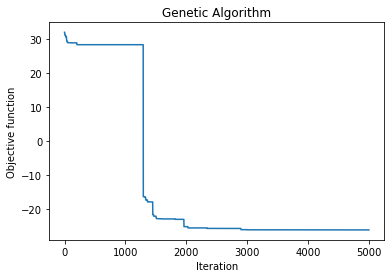

In [20]:
model.run()

In [228]:
MODEL.predict(model.best_variable.reshape(1,-1))

array([21.01596672])

In [229]:
dict(zip(FEATURES, model.best_variable))

{'max_[Ta]': 3.0,
 'max_[W]': 8.0,
 'max_[R]': 19.0,
 'max_[Tr]': 0.0,
 '[W]': 0.17738129610910447,
 '[Tr]': 0.031299539613836136,
 '[Ta]': 0.3853168047195254,
 '[R]': 0.40574151862335894,
 'length': 48.0}

In [22]:
model.

AttributeError: 'geneticalgorithm' object has no attribute 'pop'